In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
from pandas_datareader import DataReader
import seaborn as sns; sns.set(color_codes=True)
import yfinance as yf

In [2]:
start = '2021-4-16'
end = '2023-4-16'
tesla = yf.download('TSLA', start, end)
lucid = yf.download('LCID', start, end)

tesla.index = pd.to_datetime(tesla.index)
tesla['Date'] = tesla.index.date
tesla.set_index('Date', inplace=True)

lucid.index = pd.to_datetime(lucid.index)
lucid['Date'] = lucid.index.date
lucid.set_index('Date', inplace=True)

tesla=tesla.reset_index()
lucid=lucid.reset_index()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
tesla.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
tesla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,251.580603,257.350802,245.300649,251.292770,251.292770,9.351418e+07
std,63.664357,65.109190,61.824707,63.428144,63.428144,4.368952e+07
min,103.000000,111.750000,101.809998,108.099998,108.099998,2.940180e+07
25%,205.691673,209.226669,200.473335,205.815002,205.815002,6.402915e+07
50%,240.086670,246.796661,236.283340,240.546661,240.546661,8.203590e+07
75%,298.750000,304.158325,289.565002,296.856659,296.856659,1.056424e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,3.065906e+08


In [5]:
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-04-16,242.883331,249.803329,241.533340,246.593338,246.593338,83938500
1,2021-04-19,239.866669,241.800003,230.600006,238.210007,238.210007,119058600
2,2021-04-20,239.139999,245.750000,236.896667,239.663330,239.663330,106827000
3,2021-04-21,234.923340,248.279999,232.666672,248.039993,248.039993,93646500
4,2021-04-22,247.166672,251.256668,239.346664,239.896667,239.896667,106770900


In [6]:
lucid.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-04-16,20.070000,20.500000,19.250000,19.520000,19.520000,17044000
1,2021-04-19,19.870001,20.330000,18.680000,19.540001,19.540001,19552400
2,2021-04-20,19.520000,19.719999,18.309999,18.450001,18.450001,18227300
3,2021-04-21,18.299999,19.889999,17.620001,19.889999,19.889999,22545200
4,2021-04-22,20.200001,20.650000,18.900000,19.660000,19.660000,17422600


In [7]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T) 
    sigma2 = np.zeros(T)   
    F = np.zeros(T)   
    v = np.zeros(T)   
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])     
        Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [8]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)  
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
    return Y

In [9]:
#%pip install ta
from ta.momentum import RSIIndicator
from ta.trend import MACD
import getFamaFrenchFactors as gff
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Calculate OBV
tsla = tesla.copy()
tsla['daily_return'] = tsla['Adj Close'].pct_change()
tsla['direction'] = np.where(tsla['daily_return'] >= 0, 1, -1)
tsla['direction'][0] = 0
tsla['vol_adjusted'] = tsla['Volume'] * tsla['direction']
tsla['OBV'] = tsla['vol_adjusted'].cumsum()

# Calculate additional features
tsla['mom_5_20'] = (tsla['Close'] / tsla['Close'].shift(5)) - 1
tsla['mom_20_100'] = (tsla['Close'] / tsla['Close'].shift(20)) - 1
tsla['mom_60_200'] = (tsla['Close'] / tsla['Close'].shift(60)) - 1

rsi_indicator = RSIIndicator(close=tsla['Adj Close'], window=14)
macd_indicator = MACD(close=tsla['Adj Close'])

tsla['rsi'] = rsi_indicator.rsi()
tsla['macd'] = macd_indicator.macd()

# Calculate Fama French 3 factors
ff_data = gff.famaFrench3Factor(frequency='m') 
ff_data.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff_data.set_index('Date',inplace=True)
ff_data = ff_data.resample('D').interpolate()

# Reset index and convert all dates to same timezones, so they become mergable
ff_data.reset_index(inplace=True)
ff_data['Date'] = pd.to_datetime(ff_data['Date']).dt.date

tsla = ff_data.merge(tsla,on='Date')
tesla_returns = pd.DataFrame({
    'avg_close_20_days_': tsla['Adj Close'].rolling(window=20).mean().shift(1),
    'Fama_French_Mkt_RF':tsla['Mkt-RF'].shift(1),
    'mom_60_200':  tsla['mom_60_200'].shift(1),
    'TSLA_MACD':tsla['macd'].shift(1),
    'Fama_French_HML' : tsla['HML'].shift(1),
    'TSLA_CLOSE': tsla['Adj Close']
})

tesla_returns.dropna(inplace=True)

scaler = StandardScaler()
X = scaler.fit_transform(tesla_returns)

C:\Users\Umama Poonawala\AppData\Local\Temp\ipykernel_20228\2851710120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla['direction'][0] = 0


In [10]:
# Split the data into features (X) and target (y)
y = tesla_returns['TSLA_CLOSE']
X = tesla_returns.drop(columns=['TSLA_CLOSE'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Umama Poonawala\AppData\Local\Temp\ipykernel_20228\1299283086.py:9: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


         Current function value: -4.978771
         Iterations: 4
         Function evaluations: 184
         Gradient evaluations: 34


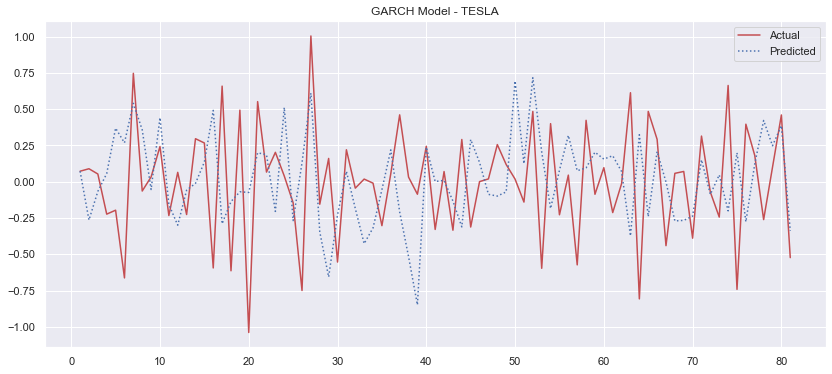

RMSE values is: 0.48487234490090175


In [11]:
# Fit a decision tree model to the data
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
Y = tree.predict(X_test)
Y = np.diff(np.log(Y))
T = Y.size

param0 = np.array([np.mean(Y), np.var(Y)/3, 0.2, 0.2])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_GARCH = GARCH_Prod(param_star.x, Y[0], T)
timevec = np.linspace(1,T,T)

fig = plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model - TESLA")
plt.show()


RMSE = np.sqrt(np.mean((Y_GARCH - Y)**2))
print('RMSE values is:', RMSE)

         Current function value: 143.464472
         Iterations: 2
         Function evaluations: 112
         Gradient evaluations: 20


C:\Users\Umama Poonawala\AppData\Local\Temp\ipykernel_20228\2126678896.py:5: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


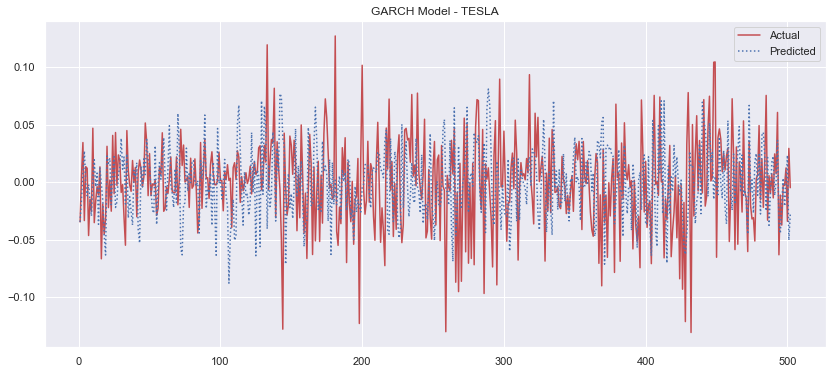

In [12]:
Y = np.diff(np.log(tesla['Adj Close'].values))
T = Y.size;

param0 = np.array([np.mean(Y), np.var(Y)/3, 0.2, 0.2])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_GARCH = GARCH_Prod(param_star.x, Y[0], T)
timevec = np.linspace(1,T,T)

fig = plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model - TESLA")
plt.show()

In [13]:
RMSE = np.sqrt(np.mean((Y_GARCH - Y)**2))
print('RMSE values is:', RMSE)

RMSE values is: 0.04736247577784268


         Current function value: 35.929693
         Iterations: 1
         Function evaluations: 131
         Gradient evaluations: 24


C:\Users\Umama Poonawala\AppData\Local\Temp\ipykernel_20228\2443430073.py:5: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


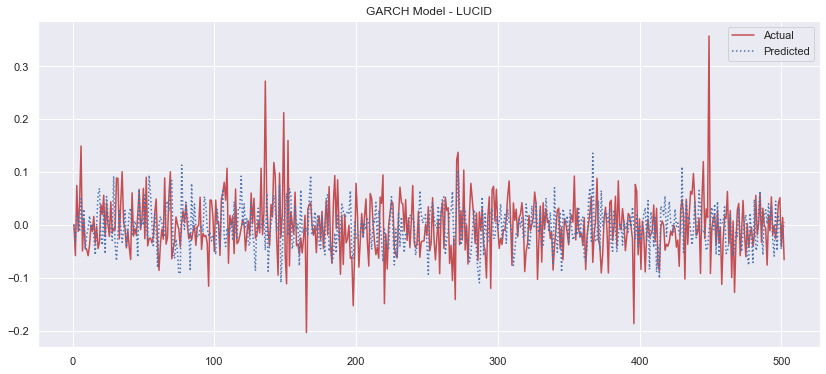

In [14]:
Y = np.diff(np.log(lucid['Adj Close'].values))
T = Y.size;

param0 = np.array([np.mean(Y), np.var(Y)/3, 0.2, 0.2])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_GARCH = GARCH_Prod(param_star.x, Y[0], T)
timevec = np.linspace(1,T,T)

fig = plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model - LUCID")
plt.show()

In [15]:
RMSE = np.sqrt(np.mean((Y_GARCH - Y)**2))
print('RMSE values is:', RMSE)

RMSE values is: 0.06575174577362274
